## Approach 1 - Continue a simple sequence of disrete spikes

**Problem**: Given a sequence with specific repetitivity (discrete), learn to continue it.

**This notebook is only for discrete classification-type problems**

1. Simple combination of two sequences, with different repeat intervals:
```
    x = 1 if x%p1==0 or x%p2==0 else 0
```    
1. Sum of sequences:
```
    x = x%p1==0 + x%p2==0 + x%p3==0`
```
1. Real-valued floats:
```
    x = sin(t)
```
1. Distribution of peridicities
    - Probability increases at around the periodicity
1. Input vectors:
```
    x = [x1, x2, x3] where x1=sin(t)  x2=t  x3= t%p1 == 0`
````
1. Something else

In [1]:
from __future__ import absolute_import, division, print_function
import os, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tnrange, tqdm_notebook

HOME = os.environ['HOME']
os.chdir(HOME+"/ninja/mxn/src/MxnVentures")
from mxn_ventures import utils

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


#### Data Models

In [83]:
x,y = gen_data2()

In [84]:
x[:200]

array([2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0])

In [82]:
def gen_data1(size=1000000):
    p1 = 4
    p2 = 7
    #x = np.array([t%p1==0 or t%p2==0 for t in range(size+1)]).astype(np.float32)
    x = np.array([t%p1==0 or t%p2==0 for t in range(size+1)])
    y = x[1:]
    x = x[:-1]
    return x, y
def gen_data2(size=1000000):
    p1 = 4
    p2 = 7
    p3 = 5
    #x = np.array([t%p1==0 or t%p2==0 for t in range(size+1)]).astype(np.float32)
    #x = np.array([[t%p1==0, t%p2==0, t%p3==0] for t in range(size+1)]).sum(axis=1)
    x = np.array([[t%p1==0, t%p2==0] for t in range(size+1)]).sum(axis=1)
    y = x[1:]
    x = x[:-1]
    return x, y
def gen_data3(size=1000000):
    p1 = 4
    p2 = 7
    #x = np.array([t%p1==0 or t%p2==0 for t in range(size+1)]).astype(np.float32)
    x = np.array([t%p1==0 or t%p2==0 for t in range(size+1)])
    y = x[1:]
    x = x[:-1]
    return x, y

### Config

#### Data Model 1

In [53]:
# Global config variables
num_steps = 15 # 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 100
#batch_size = 500
num_classes = 2
state_size = 8
learning_rate = 0.1
learning_rate = 0.2
data_model = gen_data1

##### Data Model 2

In [91]:
# Global config variables
num_steps = 10 # 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 100
#batch_size = 500
num_classes = 3
state_size = 8
learning_rate = 0.1
learning_rate = 0.2
data_model = gen_data2

#### Generate Data

In [92]:
# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps, batch_size=200, model_func=gen_data1):
    for i in range(n):
        yield gen_batch(model_func(), batch_size, num_steps)

#### Model

In [93]:
tf.reset_default_graph()

In [94]:
%%time
### Placeholders
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

### Inputs
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unpack(x_one_hot, axis=1)

### RNN
cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.rnn(cell, rnn_inputs, initial_state=init_state)

### Predictions, loss, training step
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = [tf.squeeze(i, squeeze_dims=[1]) for i in tf.split(1, num_steps, y)]

loss_weights = [tf.ones([batch_size]) for i in range(num_steps)]
losses = tf.nn.seq2seq.sequence_loss_by_example(logits, y_as_list, loss_weights)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

CPU times: user 378 ms, sys: 3.51 ms, total: 381 ms
Wall time: 392 ms


#### Training

In [97]:
def train_network(num_epochs, num_steps, state_size=4, verbose=True, data_model_func=data_model):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps, batch_size, model_func=data_model_func)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = sess.run(
                    [losses, total_loss, final_state, train_step],
                    feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.488559497893
Average loss at step 200 for last 250 steps: 0.194855508655
Average loss at step 300 for last 250 steps: 0.0652694797516
Average loss at step 400 for last 250 steps: 0.0274856968597
Average loss at step 500 for last 250 steps: 0.00988710547797
Average loss at step 600 for last 250 steps: 0.00668144829571
Average loss at step 700 for last 250 steps: 0.00529351182748
Average loss at step 800 for last 250 steps: 0.00390176885994
Average loss at step 900 for last 250 steps: 0.00320929752896

EPOCH 1
Average loss at step 100 for last 250 steps: 0.206870537307
Average loss at step 200 for last 250 steps: 0.0150448481739
Average loss at step 300 for last 250 steps: 0.00768254420254
Average loss at step 400 for last 250 steps: 0.00532406964805
Average loss at step 500 for last 250 steps: 0.00410120113054
Average loss at step 600 for last 250 steps: 0.00333536230028
Average loss at step 700 for last 250 steps: 0.00281763237203

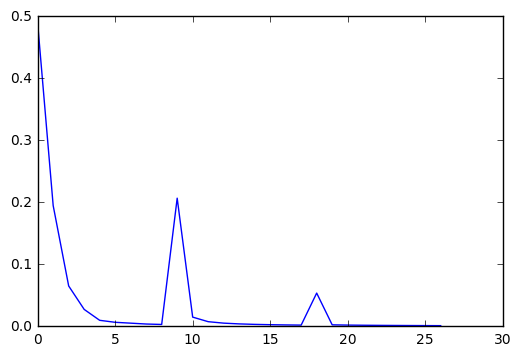

In [96]:
training_losses = train_network(3, num_steps, state_size=state_size, data_model_func=data_model)
plt.plot(training_losses)